In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras import applications
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import cv2
%matplotlib inline

Using TensorFlow backend.


In [2]:
EXTRACT_FEATURES = True
FEATURE_FILE_NAME = "inception_features2.npy"
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
def load(fname,test=False, cols=None):
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols)+['Image']]
    
    #print( df.count())
    df = df.dropna()
    columns = df.columns
    
    X = np.vstack(df['Image'].values)#/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        #y = (y-48)/48
        X, y = shuffle(X, y, random_state=20)
        y = y.astype(np.float32)
    else:
        y = None
        columns = None
    
    return X, y, columns

def load2d(fname,test=False, cols=None):
    
    X, y, columns = load(fname,test, cols)
    X = X.reshape(-1,96,96, 1)
    
    return X, y, columns

def array_to_img(x):
#     rgbimg = cv2.resize(cv2.cvtColor(x,cv2.COLOR_GRAY2RGB),(224,224))
    rgbimg = cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)
    rgbimg = rgbimg[...,::-1].astype(np.float32)
    a = np.expand_dims(rgbimg, axis=0)
    a = preprocess_input(a)
    return a

In [4]:
X, y, columns = load2d("data/training.csv",test=False)
columns = np.array(list(columns[:-1]))
columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
# mimg = X[0]
# rgbimg = cv2.resize(cv2.cvtColor(mimg,cv2.COLOR_GRAY2RGB),(224,224))
# cv2.imwrite("rgb.jpg",rgbimg)
# rgbimg = rgbimg[...,::-1].astype(np.float32)

# rgbimg.shape
# a = np.expand_dims(rgbimg, axis=0)
# print(a.shape)

# a = preprocess_input(a)
# # plt.imshow(rgbimg)

In [6]:
# inception_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg')
inception_model = applications.resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')

94658560/94653016 [==============================] - 234s 2us/step


In [7]:
# img = image.load_img("rgb.jpg", target_size=(224, 224))
# # print(img.shape)
# # convert image to numpy array
# x = image.img_to_array(img)
# print(x.shape)
# # the image is now in an array of shape (3, 224, 224) 
# # need to expand it to (1, 3, 224, 224) as it's expecting a list
# x = np.expand_dims(x, axis=0)
# print(x.shape)

# x = preprocess_input(x)
# print(x.shape)


# # print(x)
# # extract the features
# features = inception_model.predict(x)
# # convert from Numpy to a list of values
# features_arr = np.char.mod('%f', features)
# print(features_arr.shape)
# print(features.shape)
# print(np.squeeze(features))


In [8]:
inception_features = []
inception_features_array = np.zeros([X_train.shape[0],2048])

if EXTRACT_FEATURES:
    for i in range(X_train.shape[0]):
        if(i%10 == 0):
            print('.',end='')
        img = array_to_img(X_train[i])
        features = inception_model.predict(img)
#         print(features.shape)
        inception_features_array[i] = features.flatten()
    file = open(FEATURE_FILE_NAME,"wb")
#     inception_features_array = np.array(inception_features)
    np.save(file,inception_features_array)
else:
    file = open(FEATURE_FILE_NAME,'rb')
    inception_features_array = np.load(file)

......................................................................................................................................................................................

In [9]:
# inception_features_array.shape
# (inception_features_array.reshape(inception_features_array.shape[0],-1))[6]

In [10]:
# inception_features_array = (inception_features_array.reshape(inception_features_array.shape[0],-1))

In [11]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(2048)))
# model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dense(30))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
# model.summary()

In [12]:
# save best weights
checkpointer = ModelCheckpoint(filepath='face_model_in1.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 400


# X_train, X_test, y_train, y_test = train_test_split(inception_features_array, y, test_size=0.15, random_state=42)
# run model
hist = model.fit(inception_features_array,y_train, epochs=epochs, 
                 validation_split=0.15, callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model_in1.json", "w") as json_file:
    json_file.write(model_json)

Train on 1546 samples, validate on 273 samples
Epoch 1/400
 - 4s - loss: 289.3825 - acc: 0.6216 - val_loss: 280.3761 - val_acc: 0.6960

Epoch 00001: val_loss improved from inf to 280.37606, saving model to face_model_in1.h5
Epoch 2/400
 - 2s - loss: 120.2548 - acc: 0.7115 - val_loss: 373.9018 - val_acc: 0.7033

Epoch 00002: val_loss did not improve from 280.37606
Epoch 3/400
 - 2s - loss: 104.2752 - acc: 0.7076 - val_loss: 293.6228 - val_acc: 0.6960

Epoch 00003: val_loss did not improve from 280.37606
Epoch 4/400
 - 2s - loss: 101.6618 - acc: 0.7076 - val_loss: 290.8228 - val_acc: 0.7106

Epoch 00004: val_loss did not improve from 280.37606
Epoch 5/400
 - 3s - loss: 87.6462 - acc: 0.7096 - val_loss: 86.0948 - val_acc: 0.7033

Epoch 00005: val_loss improved from 280.37606 to 86.09482, saving model to face_model_in1.h5
Epoch 6/400
 - 2s - loss: 79.0178 - acc: 0.7109 - val_loss: 85.0882 - val_acc: 0.7179

Epoch 00006: val_loss improved from 86.09482 to 85.08820, saving model to face_mode

 - 3s - loss: 14.1942 - acc: 0.8260 - val_loss: 41.1541 - val_acc: 0.7582

Epoch 00056: val_loss did not improve from 30.98256
Epoch 57/400
 - 3s - loss: 16.1563 - acc: 0.8357 - val_loss: 59.3684 - val_acc: 0.7253

Epoch 00057: val_loss did not improve from 30.98256
Epoch 58/400
 - 3s - loss: 15.1423 - acc: 0.8480 - val_loss: 49.0483 - val_acc: 0.7509

Epoch 00058: val_loss did not improve from 30.98256
Epoch 59/400
 - 2s - loss: 14.2982 - acc: 0.8409 - val_loss: 32.5541 - val_acc: 0.7436

Epoch 00059: val_loss did not improve from 30.98256
Epoch 60/400
 - 3s - loss: 13.9147 - acc: 0.8325 - val_loss: 36.2978 - val_acc: 0.7656

Epoch 00060: val_loss did not improve from 30.98256
Epoch 61/400
 - 2s - loss: 13.8594 - acc: 0.8266 - val_loss: 42.2960 - val_acc: 0.7216

Epoch 00061: val_loss did not improve from 30.98256
Epoch 62/400
 - 2s - loss: 12.8067 - acc: 0.8376 - val_loss: 54.1576 - val_acc: 0.7436

Epoch 00062: val_loss did not improve from 30.98256
Epoch 63/400
 - 2s - loss: 13.832


Epoch 00113: val_loss did not improve from 24.44896
Epoch 114/400
 - 3s - loss: 8.5094 - acc: 0.8816 - val_loss: 28.5846 - val_acc: 0.7289

Epoch 00114: val_loss did not improve from 24.44896
Epoch 115/400
 - 2s - loss: 8.1508 - acc: 0.8758 - val_loss: 30.5963 - val_acc: 0.7143

Epoch 00115: val_loss did not improve from 24.44896
Epoch 116/400
 - 2s - loss: 7.7659 - acc: 0.8752 - val_loss: 33.3264 - val_acc: 0.7399

Epoch 00116: val_loss did not improve from 24.44896
Epoch 117/400
 - 2s - loss: 8.5198 - acc: 0.8700 - val_loss: 25.0983 - val_acc: 0.7326

Epoch 00117: val_loss did not improve from 24.44896
Epoch 118/400
 - 2s - loss: 8.2644 - acc: 0.8765 - val_loss: 29.2910 - val_acc: 0.7509

Epoch 00118: val_loss did not improve from 24.44896
Epoch 119/400
 - 2s - loss: 7.5996 - acc: 0.8726 - val_loss: 38.6160 - val_acc: 0.6813

Epoch 00119: val_loss did not improve from 24.44896
Epoch 120/400
 - 2s - loss: 8.0947 - acc: 0.8745 - val_loss: 43.6757 - val_acc: 0.7436

Epoch 00120: val_lo

 - 2s - loss: 5.6407 - acc: 0.8816 - val_loss: 19.9476 - val_acc: 0.7766

Epoch 00171: val_loss improved from 20.08095 to 19.94757, saving model to face_model_in1.h5
Epoch 172/400
 - 2s - loss: 6.1897 - acc: 0.8965 - val_loss: 35.1409 - val_acc: 0.7619

Epoch 00172: val_loss did not improve from 19.94757
Epoch 173/400
 - 2s - loss: 5.7569 - acc: 0.8849 - val_loss: 33.4307 - val_acc: 0.7436

Epoch 00173: val_loss did not improve from 19.94757
Epoch 174/400
 - 2s - loss: 5.9889 - acc: 0.8978 - val_loss: 21.7434 - val_acc: 0.7363

Epoch 00174: val_loss did not improve from 19.94757
Epoch 175/400
 - 2s - loss: 5.6493 - acc: 0.8920 - val_loss: 26.1672 - val_acc: 0.7839

Epoch 00175: val_loss did not improve from 19.94757
Epoch 176/400
 - 2s - loss: 5.7952 - acc: 0.8984 - val_loss: 25.1578 - val_acc: 0.7546

Epoch 00176: val_loss did not improve from 19.94757
Epoch 177/400
 - 2s - loss: 5.0394 - acc: 0.8952 - val_loss: 30.5464 - val_acc: 0.7509

Epoch 00177: val_loss did not improve from 19.

 - 2s - loss: 4.9668 - acc: 0.8972 - val_loss: 19.7547 - val_acc: 0.7473

Epoch 00229: val_loss did not improve from 17.01443
Epoch 230/400
 - 2s - loss: 4.2654 - acc: 0.9094 - val_loss: 19.4320 - val_acc: 0.7546

Epoch 00230: val_loss did not improve from 17.01443
Epoch 231/400
 - 2s - loss: 5.0199 - acc: 0.9010 - val_loss: 21.0395 - val_acc: 0.7216

Epoch 00231: val_loss did not improve from 17.01443
Epoch 232/400
 - 2s - loss: 4.6838 - acc: 0.8991 - val_loss: 17.3908 - val_acc: 0.7326

Epoch 00232: val_loss did not improve from 17.01443
Epoch 233/400
 - 2s - loss: 4.7265 - acc: 0.8978 - val_loss: 19.4730 - val_acc: 0.7326

Epoch 00233: val_loss did not improve from 17.01443
Epoch 234/400
 - 2s - loss: 4.6378 - acc: 0.8972 - val_loss: 22.0640 - val_acc: 0.7729

Epoch 00234: val_loss did not improve from 17.01443
Epoch 235/400
 - 2s - loss: 4.5780 - acc: 0.9185 - val_loss: 18.3367 - val_acc: 0.7546

Epoch 00235: val_loss did not improve from 17.01443
Epoch 236/400
 - 2s - loss: 4.6092


Epoch 00287: val_loss improved from 16.26688 to 15.67826, saving model to face_model_in1.h5
Epoch 288/400
 - 2s - loss: 3.9808 - acc: 0.9056 - val_loss: 17.0417 - val_acc: 0.7656

Epoch 00288: val_loss did not improve from 15.67826
Epoch 289/400
 - 2s - loss: 3.8616 - acc: 0.9101 - val_loss: 19.5499 - val_acc: 0.7582

Epoch 00289: val_loss did not improve from 15.67826
Epoch 290/400
 - 2s - loss: 3.9505 - acc: 0.9030 - val_loss: 18.3203 - val_acc: 0.7546

Epoch 00290: val_loss did not improve from 15.67826
Epoch 291/400
 - 2s - loss: 3.5505 - acc: 0.9088 - val_loss: 17.4149 - val_acc: 0.7473

Epoch 00291: val_loss did not improve from 15.67826
Epoch 292/400
 - 2s - loss: 3.9621 - acc: 0.9166 - val_loss: 17.9548 - val_acc: 0.7436

Epoch 00292: val_loss did not improve from 15.67826
Epoch 293/400
 - 2s - loss: 3.8354 - acc: 0.9114 - val_loss: 16.6236 - val_acc: 0.7179

Epoch 00293: val_loss did not improve from 15.67826
Epoch 294/400
 - 2s - loss: 3.8998 - acc: 0.9069 - val_loss: 15.435

 - 2s - loss: 3.5250 - acc: 0.9146 - val_loss: 15.3934 - val_acc: 0.7509

Epoch 00345: val_loss did not improve from 13.46345
Epoch 346/400
 - 2s - loss: 3.0163 - acc: 0.9185 - val_loss: 18.8352 - val_acc: 0.7106

Epoch 00346: val_loss did not improve from 13.46345
Epoch 347/400
 - 2s - loss: 3.5655 - acc: 0.9082 - val_loss: 15.2569 - val_acc: 0.7619

Epoch 00347: val_loss did not improve from 13.46345
Epoch 348/400
 - 2s - loss: 3.2810 - acc: 0.9069 - val_loss: 17.3184 - val_acc: 0.7399

Epoch 00348: val_loss did not improve from 13.46345
Epoch 349/400
 - 2s - loss: 3.2718 - acc: 0.9224 - val_loss: 19.8310 - val_acc: 0.7326

Epoch 00349: val_loss did not improve from 13.46345
Epoch 350/400
 - 2s - loss: 3.0249 - acc: 0.9120 - val_loss: 17.1823 - val_acc: 0.7656

Epoch 00350: val_loss did not improve from 13.46345
Epoch 351/400
 - 2s - loss: 3.3014 - acc: 0.9069 - val_loss: 17.8651 - val_acc: 0.7399

Epoch 00351: val_loss did not improve from 13.46345
Epoch 352/400
 - 2s - loss: 3.4074

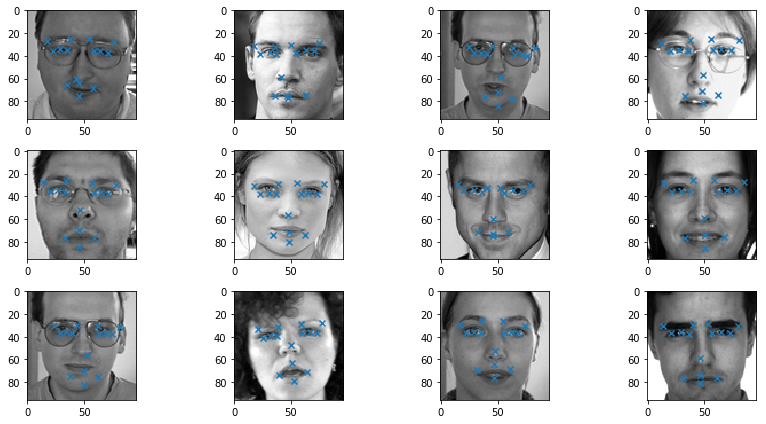

In [13]:
def keypoint_predict(x):
    img = array_to_img(x)
    features = (inception_model.predict(img)).flatten()
    return model.predict(np.array([features]))[0]
    

import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(X_test[i, :, :, 0], cmap="gray")
    p = keypoint_predict(X_test[i])
    plt.scatter(p[range(0, 30, 2)], p[range(1, 30, 2)], marker='x')

plt.tight_layout()
plt.show()

In [14]:
inception_features_array_test = np.zeros([X_test.shape[0],2048])
for i in range(X_test.shape[0]):
    img = array_to_img(X_test[i])
    features = inception_model.predict(img)
    inception_features_array_test[i] = features.flatten()
score, acc = model.evaluate(inception_features_array_test,y_test)
print(score, acc)

321/321 [==============================] - 0s 276us/step
9.910658625427436 0.7133956386292835
